In [1]:
import datetime as dt
from zoneinfo import ZoneInfo

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

from IPython.display import Image

In [2]:
sns.set_theme()

# Solar potential for a cannabis growing operation near Tessaloniki, Greece

## Energy demand

Main electric consumers:
- 110 lights with 1000W each, operating 18h per day
- 30% of the electricity needed for light is needed for HVAC

Parameters to calculate:
- daily energy consumption
- peak load

In [3]:
peak_load = {
    "light": (peak_load_light := 110), # kW
    "hvac": (peak_load_light * .3), # kW
}

daily_energy_consumption = {
    "light": peak_load_light * 18, # kWh
    "hvac": peak_load_light * .3 * 18, # kWh
}

for description, data, unit in zip(["Peak load", "Daily energy consumption"], [peak_load, daily_energy_consumption], ["kW", "kWh"]):
    print(description)
    for key, value in data.items():
        print(f"\t- {key}: {value} {unit}")
    print(f"\t- Total: {sum(data.values())} {unit}\n")


Peak load
	- light: 110 kW
	- hvac: 33.0 kW
	- Total: 143.0 kW

Daily energy consumption
	- light: 1980 kWh
	- hvac: 594.0 kWh
	- Total: 2574.0 kWh



## Weather Data

Data source: [NASA POWER](https://power.larc.nasa.gov)

Chosen location for the weather data is Pentalofos (latitude: 40.74°, longitude: 22.85°; northeast of Tessaloniki). Reason for not choosing the city directly is the effect of [_urban heat islands_](https://en.wikipedia.org/wiki/Urban_heat_island). Choosing Tessalonki directly would result in higher temperatures that might not be representative for the actual location of the operation.


- Solar radiation (direct normal & diffuse) $ \left[ \frac{kWh}{m^2 * d} \right] $
- Temperature $ \left[ °C \right] $
- Humidity $\left[ \frac{g_{H_2 O}}{g_{air}} \right]$
- Windspeed $\left[ \frac{m}{s} \right]$
- Winddirection $ \left[ ° \right]$

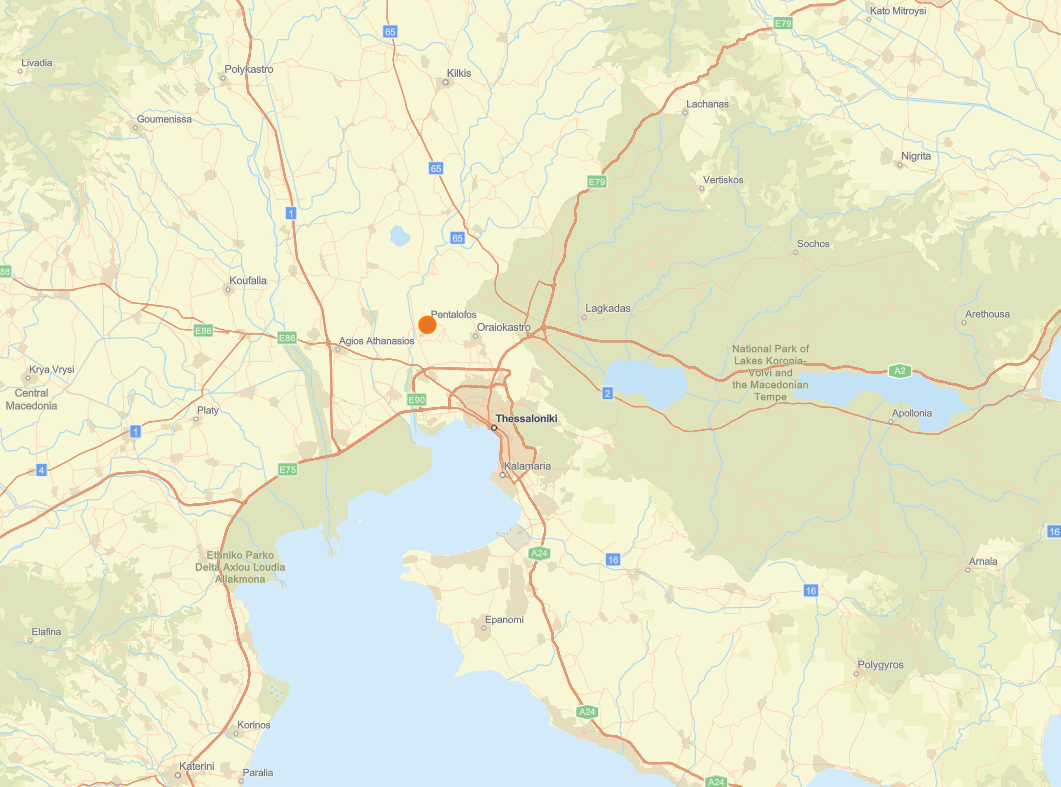

In [4]:
Image("map_tessaloniki.png")

## Analysis of weather data

Main questions:
- Seasonality: how do the parameters change throughout the year?
- Trend: is there a major trend over the years?
- Volatility: for each parameter and each month in the year, what does the distribution look like?

In [5]:
raw_df = pd.read_csv(
    "POWER_Point_Daily_19940815_20240815_040d74N_022d85E_LST.csv",
    header=14,
    na_values="-999.0",
)

tz = ZoneInfo("Europe/Athens")
def yield_dates():
    for row in raw_df.iterrows():
        data = [int(row[1][col]) for col in ["YEAR", "MO", "DY"]]
        datetime = dt.datetime(*data, tzinfo=tz)
        yield datetime

datetimes = list(yield_dates())
raw_df.set_index(pd.to_datetime(list(yield_dates())), inplace=True)

In [6]:
raw_df.tail()

,YEAR,MO,DY,T2M,QV2M,WS10M,WD10M,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF
2024-08-11 00:00:00+03:00,2024,8,11,29.73,9.95,2.09,93.19,NaN,NaN
2024-08-12 00:00:00+03:00,2024,8,12,30.15,11.23,2.06,111.81,NaN,NaN
2024-08-13 00:00:00+03:00,2024,8,13,30.85,11.47,2.04,129.19,NaN,NaN
2024-08-14 00:00:00+03:00,2024,8,14,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-15 00:00:00+03:00,2024,8,15,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10959 entries, 1994-08-15 00:00:00+03:00 to 2024-08-15 00:00:00+03:00
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YEAR                10959 non-null  int64  
 1   MO                  10959 non-null  int64  
 2   DY                  10959 non-null  int64  
 3   T2M                 10954 non-null  float64
 4   QV2M                10954 non-null  float64
 5   WS10M               10954 non-null  float64
 6   WD10M               10954 non-null  float64
 7   ALLSKY_SFC_SW_DNI   8522 non-null   float64
 8   ALLSKY_SFC_SW_DIFF  8522 non-null   float64
dtypes: float64(6), int64(3)
memory usage: 856.2 KB


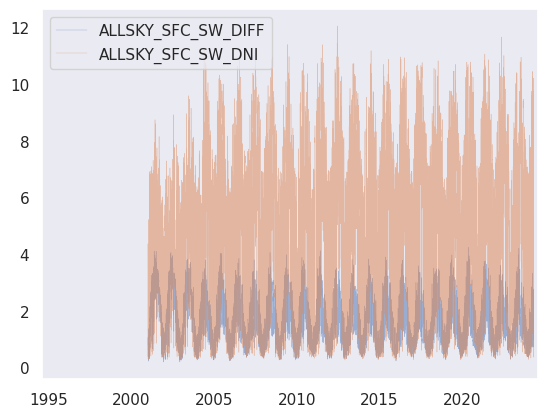

In [8]:
ax = raw_df[["ALLSKY_SFC_SW_DIFF", "ALLSKY_SFC_SW_DNI"]].plot(alpha=.5, linewidth=.3)
ax.grid()

In [9]:
# find the first date that contains irradiance data
first_date = raw_df.dropna().index[0]
last_date = raw_df.dropna().index[-1]

print(f"First date with data: {first_date}")
print(f"Last date with data: {last_date}")

First date with data: 2001-01-01 00:00:00+02:00
Last date with data: 2024-05-01 00:00:00+03:00


In [10]:
# only keep the full years of data
weather_df = raw_df[:"2023-12-31"].dropna()

### Distribution of solar radiation

Text(0.5, 0, 'Irradiance  [kW / (m² * day)]')

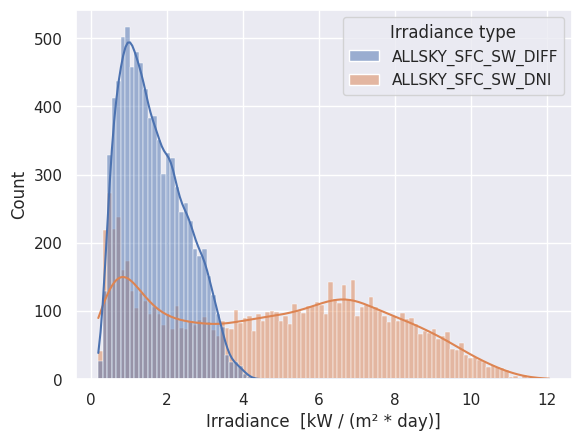

In [11]:
weather_df_melted = weather_df.melt(value_vars=["ALLSKY_SFC_SW_DIFF", "ALLSKY_SFC_SW_DNI"], var_name="Irradiance type", value_name="Irradiance")
ax = sns.histplot(data=weather_df_melted, x="Irradiance", hue="Irradiance type", bins=100, kde=True)
ax.set_xlabel("Irradiance  [kW / (m² * day)]")

In [12]:
weather_df_melted

,Irradiance type,Irradiance
0,ALLSKY_SFC_SW_DIFF,0.39
1,ALLSKY_SFC_SW_DIFF,0.82
2,ALLSKY_SFC_SW_DIFF,1.05
3,ALLSKY_SFC_SW_DIFF,0.94
4,ALLSKY_SFC_SW_DIFF,0.78
...,...,...
16795,ALLSKY_SFC_SW_DNI,6.52
16796,ALLSKY_SFC_SW_DNI,6.87
16797,ALLSKY_SFC_SW_DNI,6.27
16798,ALLSKY_SFC_SW_DNI,2.19


In [13]:
# group by month; use sensible aggregation functions
monthly_weather_df = weather_df.resample("ME").agg({
    "ALLSKY_SFC_SW_DIFF": "sum",
    "ALLSKY_SFC_SW_DNI": "sum",
    "T2M": "mean",
    "WS10M": "mean",
    "WD10M": "mean",
    "QV2M": "mean",
})

In [14]:
monthly_weather_df["WD10M_sin"] = np.sin(monthly_weather_df["WD10M"]*np.pi/180)
monthly_weather_df.head()

,ALLSKY_SFC_SW_DIFF,ALLSKY_SFC_SW_DNI,T2M,WS10M,WD10M,QV2M,WD10M_sin
2001-01-31 00:00:00+02:00,23.98,43.84,5.625484,3.471290,140.560000,5.117742,0.635270
2001-02-28 00:00:00+02:00,39.66,100.18,6.423214,3.295000,203.635714,4.691429,-0.400920
2001-03-31 00:00:00+03:00,67.85,92.09,12.304516,3.321613,179.558387,6.277742,0.007708
2001-04-30 00:00:00+03:00,79.98,102.06,12.548667,3.634000,172.597667,6.484333,0.128836
2001-05-31 00:00:00+03:00,93.57,116.48,17.633548,2.852581,173.635161,8.280968,0.110859


### Overall trend

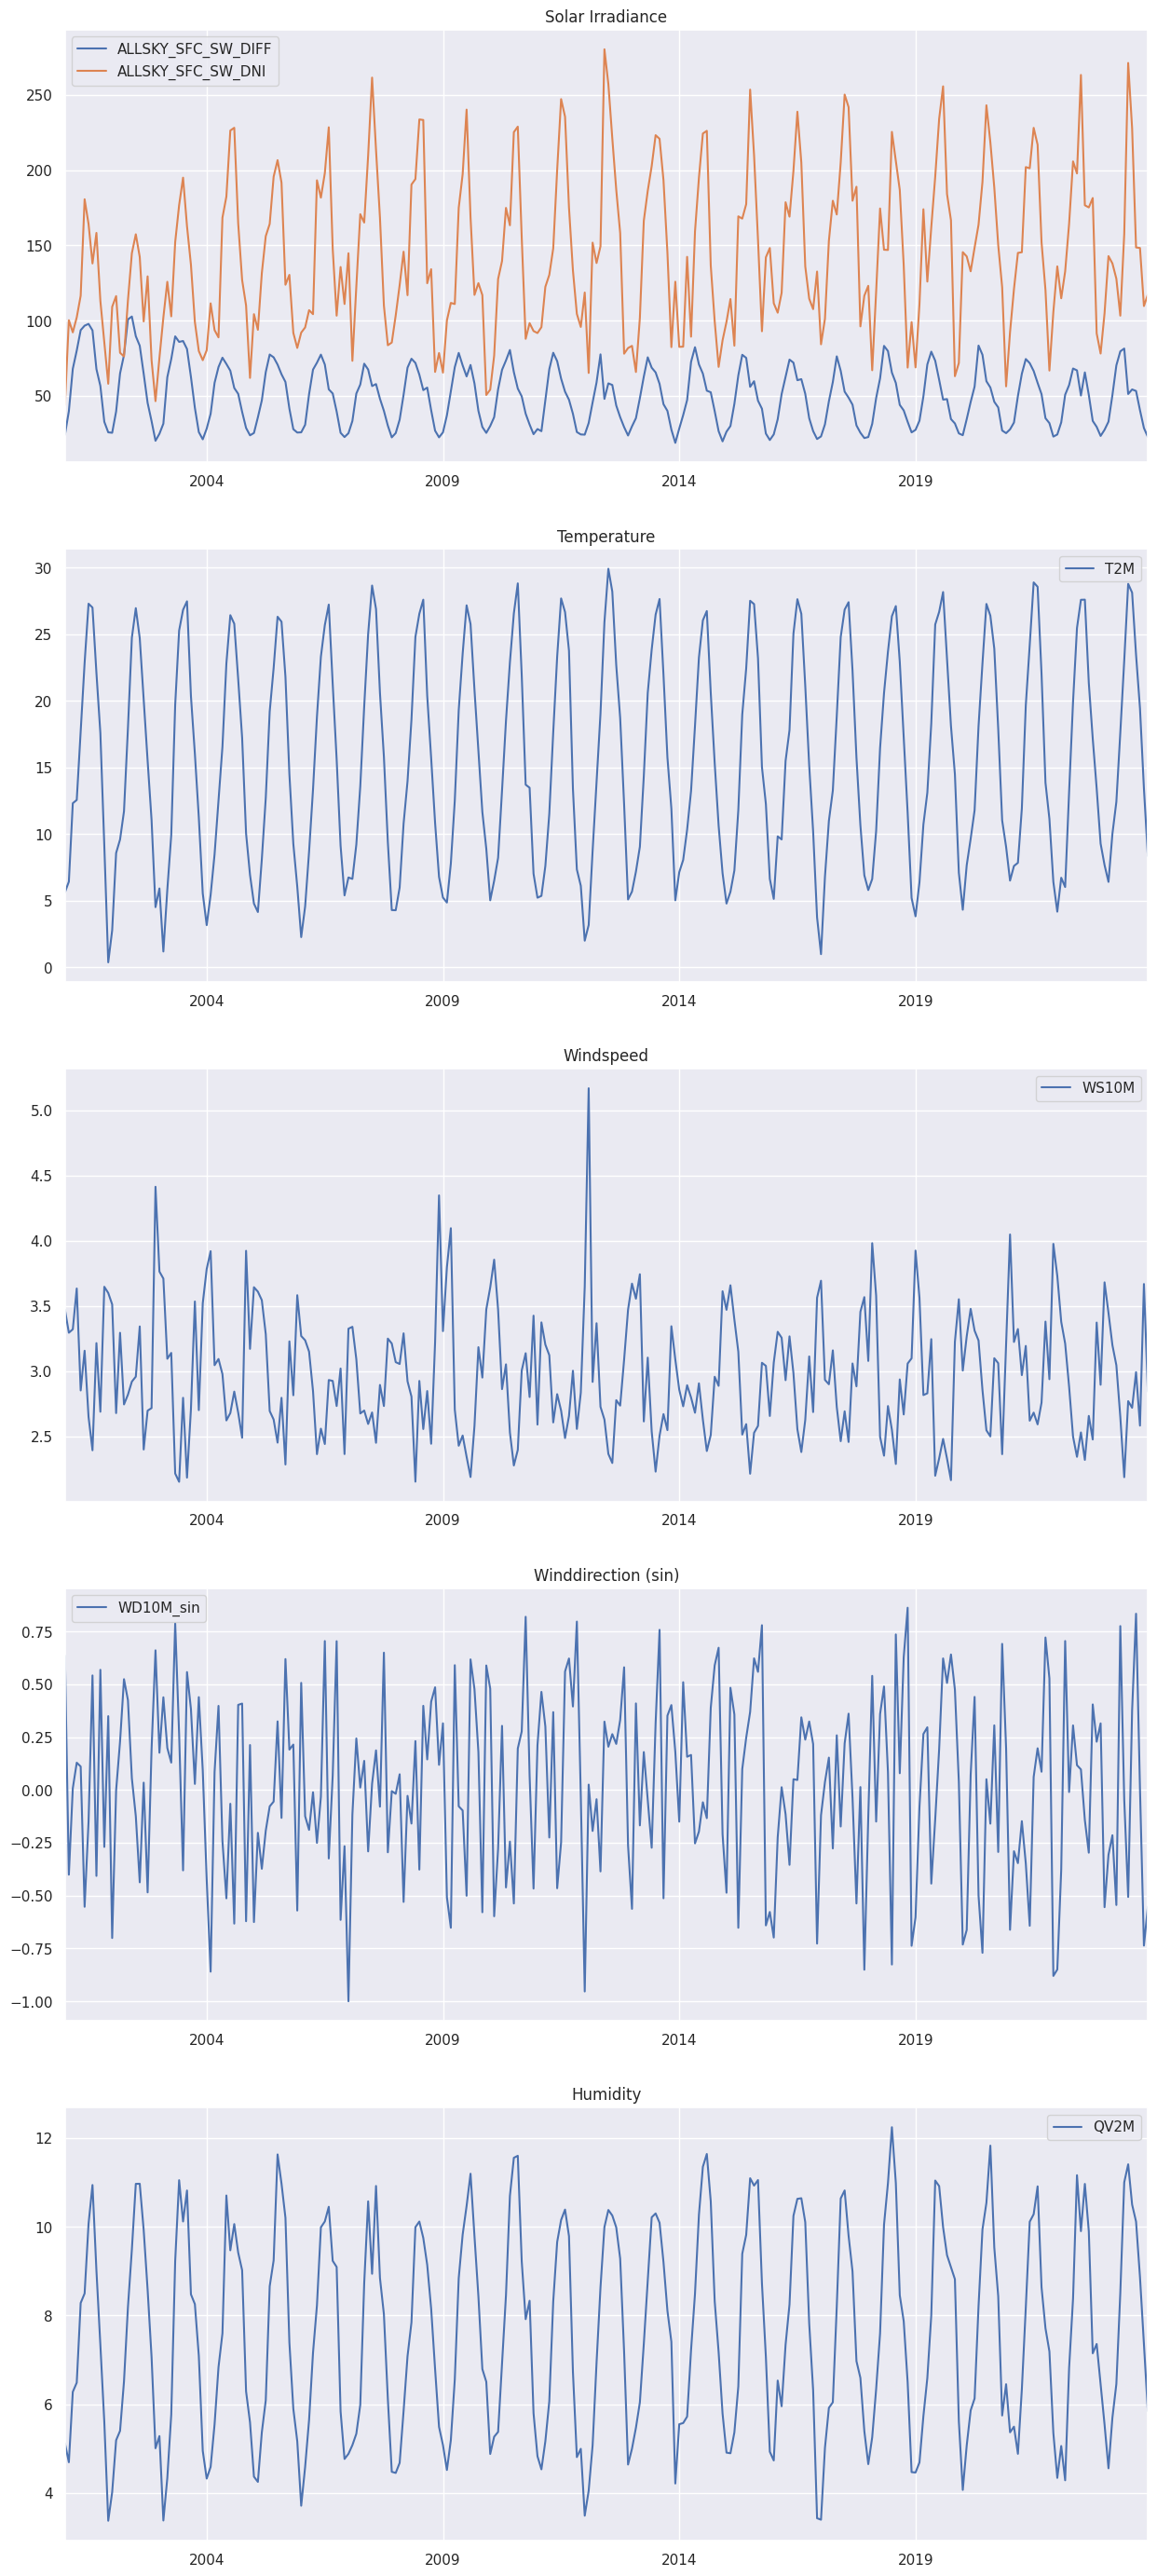

In [24]:
fig, axs = plt.subplots(5, 1, figsize=(15, 7 * 5))

title_to_data = {
    "Solar Irradiance": ["ALLSKY_SFC_SW_DIFF", "ALLSKY_SFC_SW_DNI"],
    "Temperature": ["T2M"],
    "Windspeed": ["WS10M"],
    "Winddirection (sin)": ["WD10M_sin"],
    "Humidity": ["QV2M"],
}

for ax, (title, data_cols) in zip(axs, title_to_data.items()):
    monthly_weather_df[data_cols].plot(ax=ax, title=title)
    ax.grid(True)

### Seasonality

Group the data by month and make boxplots to show the distribution

Text(0.5, 1.0, 'Boxplot of irradiance per month (2001-2023)')

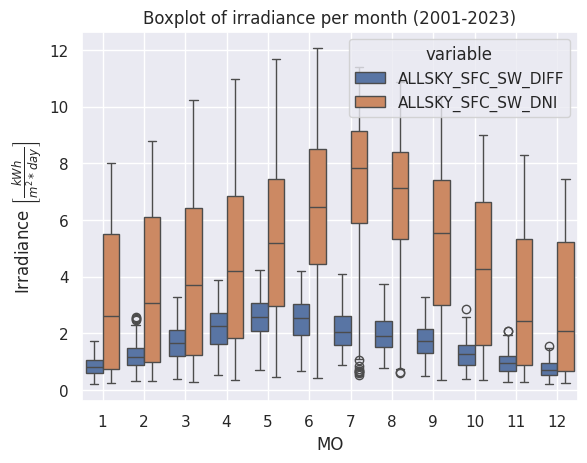

In [25]:
irradiance_melted = raw_df.dropna()[["MO", "ALLSKY_SFC_SW_DIFF", "ALLSKY_SFC_SW_DNI"]].melt(id_vars=["MO"])
ax = sns.boxplot(data=irradiance_melted, x="MO", y="value", hue="variable")
ax.grid(True)
ax.set_ylabel(r"Irradiance $ \left[ \frac{kWh}{m^2 * day} \right] $")
ax.set_title("Boxplot of irradiance per month (2001-2023)")

## Regulatory environment in Greece

In Greece, solar energy investment is incentivized through two primary mechanisms: feed-in tariffs (FiTs) and net metering. These programs, managed by regulatory bodies such as the Regulatory Authority for Energy (RAE), the Hellenic Electricity Distribution Network Operator (HEDNO), and the Ministry of Environment and Energy, provide different financial benefits and cater to various needs of solar energy producers, whether they are businesses, households, or public entities.

### Feed-in Tariffs (FiTs)

**FiTs** are designed to offer a fixed payment for every kilowatt-hour (kWh) of electricity generated by solar installations and fed into the national grid. The rates under FiTs are typically determined through competitive auctions and are guaranteed for a specific period, usually 20 years. This long-term, predictable income stream makes FiTs particularly attractive for those looking to generate steady revenue from their solar investments. Smaller-scale solar projects often benefit more from higher FiT rates, whereas larger projects usually need to secure their rates through auctions. FiTs are especially suitable for investors who prioritize income generation over self-consumption of electricity.

### Net Metering

**Net metering**, in contrast, allows solar energy producers to offset their electricity consumption with the power they generate. If a solar system produces more electricity than is consumed on-site, the excess is fed into the grid, and the producer receives a credit that can be used to offset future electricity bills. This scheme is beneficial for those who want to primarily reduce their energy costs by using the solar power they generate, making it ideal for residential and small business installations. Net metering participants benefit indirectly through reduced electricity costs rather than receiving direct payments, aligning this option more with the goal of energy independence and cost savings rather than profit generation.

### Grants, Subsidies, and Tax Incentives

Solar energy investors in Greece also have access to a variety of grants, subsidies, and tax incentives aimed at reducing the initial costs and enhancing the financial viability of solar projects. Key financial supports include:

1. **Investment Incentive Laws**: 
   - Law 4399/2016 provides a framework for state aid that includes tax relief, leasing subsidies, and employment subsidies for renewable energy projects. These incentives are aimed at encouraging private investment in solar energy, especially when integrated into broader infrastructure or energy efficiency initiatives.

2. **EU Structural Funds**: 
   - Greece benefits from significant EU funding, particularly through the European Regional Development Fund (ERDF) and the European Agricultural Fund for Rural Development (EAFRD). These funds support energy efficiency, renewable energy projects, and rural development, providing grants that can co-finance solar energy systems. These funds are accessible to a wide range of applicants, including small and medium-sized enterprises (SMEs) and public sector entities.

3. **National Development Program (ESPA)**: 
   - ESPA 2021-2027 includes funding for energy-related projects, supporting the installation of renewable energy systems and energy efficiency measures. This program is a critical source of financial support for solar energy projects across different sectors.

4. **Green Fund (Πράσινο Ταμείο)**: 
   - The Green Fund provides financial support for environmental and sustainable development projects, including solar energy installations. This national fund targets projects that contribute to environmental protection and sustainability.

5. **Tax Incentives**: 
   - These include reduced VAT rates on solar energy systems and accelerated depreciation allowances, which allow businesses to write off the cost of their solar installations more quickly, reducing their taxable income.

6. **Energy Communities**: 
   - Greece promotes the formation of energy communities, cooperative entities that own and manage renewable energy installations, including solar. These communities can access various funding mechanisms and benefit from grants, low-interest loans, and other subsidies that support collective investment in renewable energy.

### Choosing Between FiTs and Net Metering

Choosing between FiTs and net metering depends on the specific goals of the investor. FiTs are more suited for those looking for a guaranteed return on investment through direct payments, while net metering is ideal for those seeking to reduce their electricity bills and use solar energy primarily for self-consumption.

### Conclusion

In summary, Greece offers a robust framework for supporting solar energy through a combination of feed-in tariffs, net metering, and various financial incentives. Investors must choose between FiTs and net metering based on their financial goals and energy consumption patterns. Meanwhile, the availability of grants, subsidies, and tax breaks further enhances the attractiveness of solar investments, contributing to the country’s broader goals of increasing renewable energy adoption and reducing carbon emissions.


## Solar system design

The main design goal for the solar system is to provide CO2-neutrality for the operation. That means the energy generated within one year should equal the consumption.

### Solar array tilt angle

The optimal tilt angle depends on the time of the year and the latitude. If the yield should be optimimal throughout the year with a fixed angle of 40°, facing south. 


### Specific cost

The main components of a solar system including their [specific cost](https://chatgpt.com/share/9cbdee72-104e-4095-a3db-3f5e59d6600e) are:
- solar panel array (~ 1100€ per kW)
- central equipment (inverters, charge controllers, etc.; ~ 200€ per kW)
- battery bank (~ 3500€ per kW)

In [17]:
yearly_energy_consumption = sum(daily_energy_consumption.values()) * 365
print(f"Yearly energy consumption: {yearly_energy_consumption / 1e3} MWh")
print(f"Specific cost of electricity: 150 €/MWh")
print(f"Yearly energy cost: {yearly_energy_consumption / 1e3 * 150} €")

Yearly energy consumption: 939.51 MWh
Specific cost of electricity: 150 €/MWh
Yearly energy cost: 140926.5 €


### Panel array size

<Axes: >

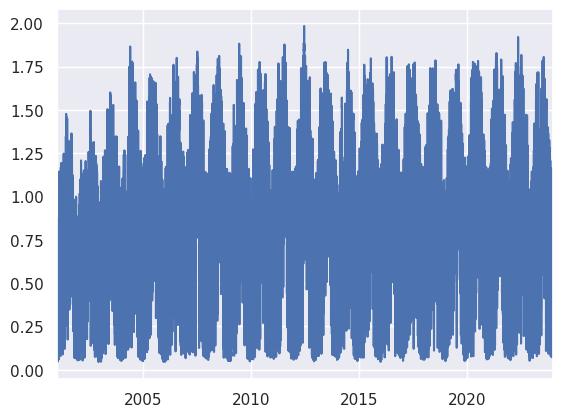

In [18]:
panel_area = 1.086 * 2.278  # m^2
panel_efficiency = 0.2
system_efficiency = 0.9
panel_tilt_angle = 40  # degrees
albedo = 0.2


def yield_panel_yield(panel_tilt_angle=panel_tilt_angle):
    for row in weather_df.iterrows():
        index, data = row
        irradiance_tilted = (
            data["ALLSKY_SFC_SW_DNI"] * (1 + np.cos(panel_tilt_angle * np.pi / 180)) / 2
            + data["ALLSKY_SFC_SW_DIFF"]
            * (1 - np.cos(panel_tilt_angle * np.pi / 180))
            / 2
            + albedo
            * data["ALLSKY_SFC_SW_DNI"]
            * (1 - np.cos(panel_tilt_angle * np.pi / 180))
            / 2
        )
        yield index, irradiance_tilted * panel_efficiency * system_efficiency  # kWh / m^2


def get_tilted_series(panel_tilt_angle):
    index, specific_yield = zip(*yield_panel_yield(panel_tilt_angle))
    return pd.Series(specific_yield, index=index)


index, specific_yield = zip(*yield_panel_yield())
tilted_surface_yield = pd.Series(specific_yield, index=index)
tilted_surface_yield.plot()

<Axes: title={'center': 'Specific yield per year on inclined surface'}, ylabel='$ kWh / m² $'>

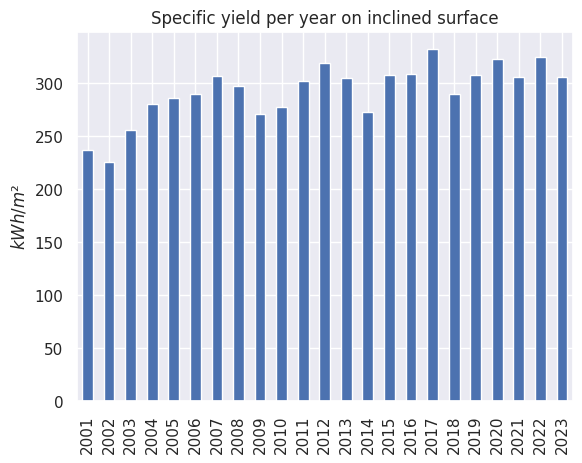

In [19]:
specific_yield_per_year = tilted_surface_yield.groupby(tilted_surface_yield.index.year).sum()
specific_yield_per_year.plot(kind="bar", title="Specific yield per year on inclined surface", ylabel="$ kWh / m² $")

In [20]:
weakest_year = specific_yield_per_year.idxmin()

print_data = {
    f"Weakest year ({weakest_year})": yearly_energy_consumption / specific_yield_per_year[weakest_year],
    f"Mean year ({specific_yield_per_year.mean():.0f} kWh/m²)": yearly_energy_consumption / specific_yield_per_year.mean(),
}

print("Panel array for")
for key, value in print_data.items():
    print(f"\t- {key}:")
    print(f"\t\tArray area: {value:.2f} m²")
    print(f"\t\tPanel count (550Wp): {value / panel_area:.0f}")
    print(f"\t\tPeak power: {value / panel_area * 0.55:.0f} kWp")
    print(f"\t\tApproximate cost: {value / panel_area * 0.55 * 1100:.0f} €")


Panel array for
	- Weakest year (2002):
		Array area: 4165.47 m²
		Panel count (550Wp): 1684
		Peak power: 926 kWp
		Approximate cost: 1018675 €
	- Mean year (293 kWh/m²):
		Array area: 3211.31 m²
		Panel count (550Wp): 1298
		Peak power: 714 kWp
		Approximate cost: 785333 €


### Simulation of deficit / surplus

In [21]:
from dataclasses import dataclass

@dataclass
class Battery:
    capacity: float # kWh
    efficiency: float
    soc: float = 0 # kWh

    def charge(self, energy: float) -> float:
        difference =  self.soc + energy * self.efficiency - self.capacity
        if difference > 0:
            # we have surplus energy -> set charge to capacity
            self.soc = self.capacity
        else:
            self.soc = self.soc + energy * self.efficiency
            difference = 0
        return difference / self.efficiency

    def discharge(self, energy: float) -> float:
        potential_discharge = energy / self.efficiency
        difference = self.soc - potential_discharge
        if difference < 0:
            # battery fully drained -> set charge to 0
            self.soc = 0
        else:
            self.soc = self.soc - potential_discharge
            difference = 0

        return difference * self.efficiency

    def __repr__(self):
        return f"Battery(capacity={self.capacity}, efficiency={self.efficiency}, charge={self.soc})"



def simulate_system(specific_yield: pd.Series, consumption: pd.Series, panel_area: float, battery: Battery) -> pd.DataFrame:
    df = pd.DataFrame({"yield": specific_yield * panel_area, "consumption": consumption, "battery_soc": 0., "battery": 0., "grid": 0.})
    
    for index, row in df.iterrows():
        surplus = row["yield"] - row["consumption"]
        if surplus > 0:
            difference = battery.charge(surplus)
        elif surplus < 0:
            difference = battery.discharge(-surplus)
        else:
            difference = 0.
        df.loc[index, "grid"] = - difference
        df.loc[index, "battery"] = min(0, surplus - difference)
        df.loc[index, "battery_soc"] = battery.soc
    return df

battery = Battery(capacity=3000, efficiency=0.9)
daily_energy_consumption = pd.Series(2500, index=tilted_surface_yield.index)
simulation_df = simulate_system(tilted_surface_yield, daily_energy_consumption, 3000, battery)

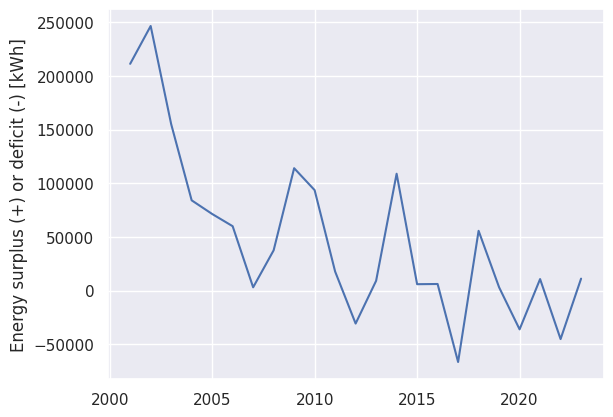

In [26]:
ax = simulation_df.grid.groupby(simulation_df.index.year).sum().plot()
ax.set_ylabel("Energy surplus (+) or deficit (-) [kWh]")
ax.grid(True)
ax.set_label("Energy balance per year of system with 3000 m² panel array and 3000 kWh battery")